<a href="https://colab.research.google.com/github/sk-725/heart-failure-model/blob/main/heart_failure_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Interactive Widgets
from ipywidgets import interact, IntSlider, FloatSlider
import ipywidgets as widgets


In [23]:
# Update the path according to your Drive
df = pd.read_csv('/content/drive/My Drive/heart.csv')

# Basic info
print("Dataset Shape:", df.shape)
display(df.head())
print("\nMissing values per column:\n", df.isnull().sum())


Dataset Shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



Missing values per column:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [24]:
# Common target names in heart datasets
possible_targets = ["target", "Target", "outcome", "HeartDisease", "heart_disease"]

target_col = None
for col in df.columns:
    if col in possible_targets:
        target_col = col
        break

if target_col is None:
    target_col = df.columns[-1]  # fallback: last column
    print(f"No standard target column found. Using last column '{target_col}' as target.")

print(f"Target column used: '{target_col}'")


Target column used: 'HeartDisease'


/tmp/ipython-input-4266261233.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette="Set2")


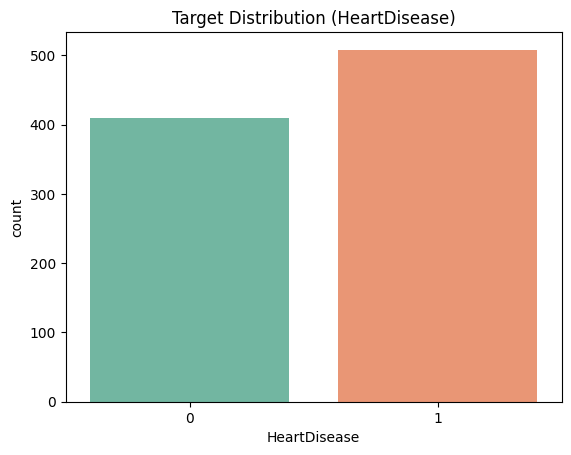

In [25]:
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title(f"Target Distribution ({target_col})")
plt.show()


In [26]:
X = df.drop(target_col, axis=1)
y = df[target_col]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (918, 11)
Target shape: (918,)


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a column transformer for preprocessing
# One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Create a preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing to the training and testing data separately
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)


print("Train/Test split and preprocessing done!")
print("X_train_scaled:", X_train_scaled.shape, "X_test_scaled:", X_test_scaled.shape)

Train/Test split and preprocessing done!
X_train_scaled: (734, 20) X_test_scaled: (184, 20)


In [30]:
param_grid_rf = {
    'n_estimators': [100,200,300,400,500],
    'max_depth': [None,5,10,15,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, param_distributions=param_grid_rf,
                               n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train_scaled, y_train)
y_pred_rf = rf_random.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("Best Random Forest Params:", rf_random.best_params_)
print("Random Forest Accuracy:", round(rf_acc*100,2), "%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': False}
Random Forest Accuracy: 90.22 %


In [31]:
param_grid_xgb = {
    'n_estimators':[100,200,300,400],
    'max_depth':[3,5,7,10],
    'learning_rate':[0.01,0.05,0.1,0.2],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,1.0],
    'gamma':[0,0.1,0.2]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_random = RandomizedSearchCV(xgb, param_distributions=param_grid_xgb,
                                n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)

xgb_random.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_random.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print("Best XGBoost Params:", xgb_random.best_params_)
print("XGBoost Accuracy:", round(xgb_acc*100,2), "%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:06:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
XGBoost Accuracy: 89.13 %


In [32]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, y_pred_lr)

print("Model Accuracies after tuning:")
print(f"Logistic Regression: {round(lr_acc*100,2)}%")
print(f"Tuned Random Forest: {round(rf_acc*100,2)}%")
print(f"Tuned XGBoost: {round(xgb_acc*100,2)}%")


Model Accuracies after tuning:
Logistic Regression: 88.59%
Tuned Random Forest: 90.22%
Tuned XGBoost: 89.13%



Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



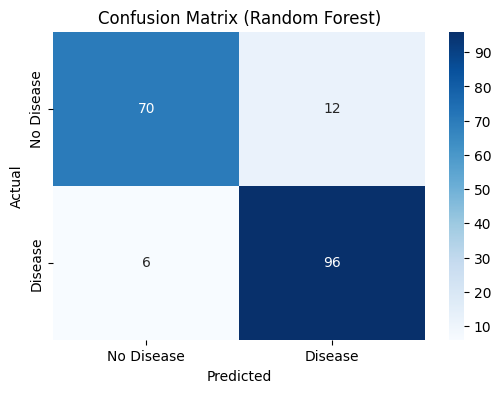

In [33]:
# Choose best model (use the one with highest accuracy)
if rf_acc >= xgb_acc:
    best_model = rf_random
    best_pred = y_pred_rf
    model_name = "Random Forest"
else:
    best_model = xgb_random
    best_pred = y_pred_xgb
    model_name = "XGBoost"

print(f"\nClassification Report for {model_name}:\n")
print(classification_report(y_test, best_pred))

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Disease","Disease"],
            yticklabels=["No Disease","Disease"])
plt.title(f"Confusion Matrix ({model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [35]:
# Interactive input function
def predict_heart(**kwargs):
    # Create DataFrame from input
    new_patient = pd.DataFrame([kwargs])
    # Scale features using the fitted pipeline
    new_patient_processed = pipeline.transform(new_patient)
    # Predict using best model
    pred = best_model.predict(new_patient_processed)[0]
    prob = best_model.predict_proba(new_patient_processed)[0]

    if pred == 1:
        print("Prediction: Patient is likely to have heart disease ❤️")
    else:
        print("Prediction: Patient is unlikely to have heart disease 💚")
    print("Prediction probabilities (No Disease, Disease):", prob)

# Create sliders for each feature
sliders = {}
for col in X.columns:
    if X[col].dtype == np.int64 or X[col].dtype == np.int32:
        sliders[col] = IntSlider(min=int(X[col].min()), max=int(X[col].max()), step=1, value=int(X[col].median()))
    elif X[col].dtype == np.float64:
         sliders[col] = FloatSlider(min=float(X[col].min()), max=float(X[col].max()), step=0.1, value=float(X[col].median()))
    else: # Handle categorical features
        unique_values = X[col].unique()
        sliders[col] = widgets.Dropdown(options=unique_values, value=unique_values[0], description=col)


interact(predict_heart, **sliders)

interactive(children=(IntSlider(value=54, description='Age', max=77, min=28), Dropdown(description='Sex', opti…

<function __main__.predict_heart(**kwargs)>